In [1]:
import gevfit
import analysis
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from sklearn.utils import resample

### Experiments 38-46: Stampede Skylake on 256 Ranks
### Experiments 28-37: Stampede Skylake on 512 Ranks
### Experiments 47-49: Stampede Skylake on 1024 Ranks

#### Each Experiment Contains 4 Verbose Runs:
- DGemm: a=256, b=64, 500 iterations, no interference
- DGemm: a=256, b=64, 500 iterations, stencil size 32768
- DGemm: a=256, b=64, 500 iterations, rabbit workload
- DGemm: a=256, b=64, 500 iterations, both stencil and rabbit workload

In [2]:
# Get DataFrame of All Experiments
df_All = analysis.getAllExperiments()

# Get only Stampede 256 Rank data
df_Stampede256 = df_All[(df_All['Experiment'] == 38) | 
                    (df_All['Experiment'] == 39) | 
                    (df_All['Experiment'] == 40) | 
                    (df_All['Experiment'] == 41) |
                    (df_All['Experiment'] == 42) | 
                    (df_All['Experiment'] == 43) | 
                    (df_All['Experiment'] == 44) | 
                    (df_All['Experiment'] == 45) | 
                    (df_All['Experiment'] == 46) ]

# Get only Stampede 512 Rank data
df_Stampede512 = df_All[(df_All['Experiment'] == 28) | 
                    (df_All['Experiment'] == 29) | 
                    (df_All['Experiment'] == 30) | 
                    (df_All['Experiment'] == 31) |
                    (df_All['Experiment'] == 32) | 
                    (df_All['Experiment'] == 33) | 
                    (df_All['Experiment'] == 34) | 
                    (df_All['Experiment'] == 35) | 
                    (df_All['Experiment'] == 36) | 
                    (df_All['Experiment'] == 37) ]

# Get only Stampede 1024 Rank data
df_Stampede1024 = df_All[(df_All['Experiment'] == 47) | 
                    (df_All['Experiment'] == 48) | 
                    (df_All['Experiment'] == 49) ]

## Plots all of the Total Runtimes as a Function of Number of Ranks to Visualize Variance

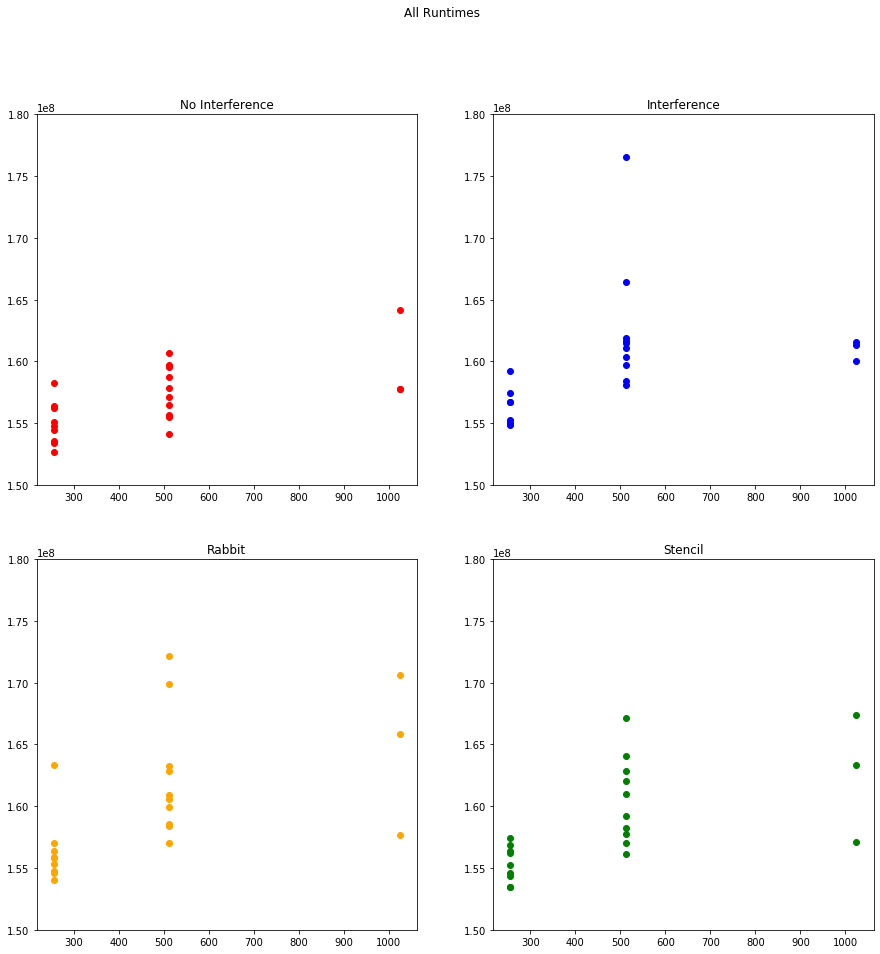

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('All Runtimes')

NoInterferenceMeta = pd.DataFrame(columns=['Ranks', 'Runtime'])
InterferenceMeta = pd.DataFrame(columns=['Ranks', 'Runtime'])
RabbitMeta = pd.DataFrame(columns=['Ranks', 'Runtime'])
StencilMeta = pd.DataFrame(columns=['Ranks', 'Runtime'])

for df in [df_Stampede256, df_Stampede512, df_Stampede1024]:
    for run in range(0, len(df)):
        label = ''
        
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        ranks = currentRun['processors']
        stencil = currentRun['stencil_size']
        rab_work = currentRun['rabbit_workload']
        iterations = currentRun['iterations']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        
        currentRunTime = currentData['interval_max_usec'].sum()
        
        if int(stencil) > 0:
            label = label + 'Stencil '
        if int(rab_work) > 0:
            label = label + 'Rabbit '
            
        if label == '':
            axs[0][0].plot(int(ranks), currentRunTime, 'o', color='red')
            NoInterferenceMeta.loc[len(NoInterferenceMeta)] = [int(ranks), currentRunTime]
        elif label == 'Stencil ':
            axs[1][0].plot(int(ranks), currentRunTime, 'o', color='orange')
            StencilMeta.loc[len(StencilMeta)] = [int(ranks), currentRunTime]
        elif label == "Rabbit ":
            axs[1][1].plot(int(ranks), currentRunTime, 'o', color='green')
            RabbitMeta.loc[len(RabbitMeta)] = [int(ranks), currentRunTime]
        else:
            axs[0][1].plot(int(ranks), currentRunTime, 'o', color='blue')
            InterferenceMeta.loc[len(InterferenceMeta)] = [int(ranks), currentRunTime]

_ = axs[0][0].set_ylim([1.5*10**8, 1.8*10**8])
_ = axs[0][0].set_title('No Interference')

_ = axs[0][1].set_ylim([1.5*10**8, 1.8*10**8])
_ = axs[0][1].set_title('Interference')

_ = axs[1][0].set_ylim([1.5*10**8, 1.8*10**8])
_ = axs[1][0].set_title('Rabbit')

_ = axs[1][1].set_ylim([1.5*10**8, 1.8*10**8])
_ = axs[1][1].set_title('Stencil')

## Write Meta Data (Runtimes) from CSV files to Save Time

In [14]:
NoInterferenceMeta.to_csv('StampedeNoInterference.csv')
InterferenceMeta.to_csv('StampedeInterference.csv')
RabbitMeta.to_csv('StampedeRabbit.csv')
StencilMeta.to_csv('StampedeStencil.csv')

## Read Meta Data (Runtimes) from CSV files to Save Time

In [3]:
NoInterferenceMeta = pd.read_csv('StampedeNoInterference.csv', index_col=0)
InterferenceMeta = pd.read_csv('StampedeInterference.csv', index_col=0)
RabbitMeta = pd.read_csv('StampedeRabbit.csv', index_col=0)
StencilMeta = pd.read_csv('StampedeStencil.csv', index_col=0)

### Get All 256 Rank Runs from Stampede

In [4]:
# Get Runs on Stampede with 256 Ranks  
df_Stampede256_NoInterference = df_Stampede256[(df_Stampede256['workload'] == 'dgemm') & (df_Stampede256['stencil_size'] == 0) & (df_Stampede256['rabbit'] == 0) & (df_Stampede256['rabbit_workload'] == 0) & (df_Stampede256['osu'] == 0)]
df_Stampede256_Interference = df_Stampede256[(df_Stampede256['workload'] == 'dgemm') & (df_Stampede256['stencil_size'] ==32768) & (df_Stampede256['rabbit'] == 0) & (df_Stampede256['rabbit_workload'] == 1) & (df_Stampede256['osu'] == 0)]
df_Stampede256_Stencil_NoInterference = df_Stampede256[(df_Stampede256['workload'] == 'dgemm') & (df_Stampede256['stencil_size'] ==32768) & (df_Stampede256['rabbit'] == 0) & (df_Stampede256['rabbit_workload'] == 0) & (df_Stampede256['osu'] == 0)]
df_Stampede256_Interference_NoStencil = df_Stampede256[(df_Stampede256['workload'] == 'dgemm') & (df_Stampede256['stencil_size'] ==0) & (df_Stampede256['rabbit'] == 0) & (df_Stampede256['rabbit_workload'] == 1) & (df_Stampede256['osu'] == 0)]

### Based off of 256 Rank Runs, Generate Confidence Interval and Overlay with Actual Runtimes

Interference
No Interference
Stencil
Rabbit


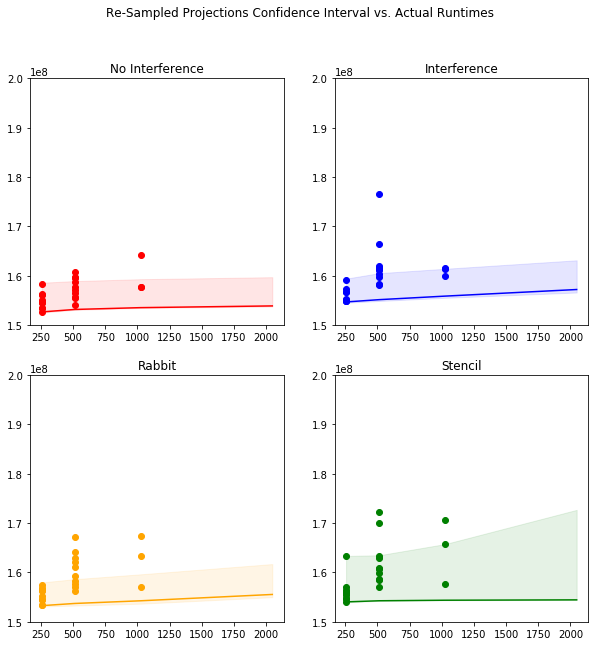

In [5]:
baseranks = 256
kvals = np.array([1, 2, 4, 8])
iterations = 20
cutoff = 1 # ~90% confidence interval with iterations = 20

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Re-Sampled Projections Confidence Interval vs. Actual Runtimes')

count = 0
labels = ['Interference', 'No Interference', 'Stencil', 'Rabbit']

for df in [df_Stampede256_Interference, df_Stampede256_NoInterference, df_Stampede256_Stencil_NoInterference, df_Stampede256_Interference_NoStencil]:    
    print(labels[count])
    
    lowerBound = []
    median = []
    upperBound = []
    for k in kvals:   
        expList = []
        for run in range(0, len(df)):
            currentRun = df.iloc[run]
            eid = currentRun['Experiment']
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            
            for i in range(iterations):
                data = analysis.resample_project(currentData, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(data)
                expList.append(projectedRunTime)
            expList.sort()
        
        lowerBound.append(expList[0])
        median.append(expList[int(iterations / 2)])
        upperBound.append(expList[-1])
    
    if count == 0:
        _ = axs[0][1].plot(baseranks * kvals, median, color='blue')
        _ = axs[0][1].fill_between(baseranks * kvals, lowerBound, upperBound, color='blue', alpha=.1)
    if count == 1:
        _ = axs[0][0].plot(baseranks * kvals, median, color='red')
        _ = axs[0][0].fill_between(baseranks * kvals, lowerBound, upperBound, color='red', alpha=.1)
    if count == 2:
        _ = axs[1][1].plot(baseranks * kvals, median, color='green')
        _ = axs[1][1].fill_between(baseranks * kvals, lowerBound, upperBound, color='green', alpha=.1)
    if count == 3:
        _ = axs[1][0].plot(baseranks * kvals, median, color='orange')
        _ = axs[1][0].fill_between(baseranks * kvals, lowerBound, upperBound, color='orange', alpha=.1)
    count = count + 1

_ = axs[0][0].plot(NoInterferenceMeta['Ranks'], NoInterferenceMeta['Runtime'], 'o', color='red')
_ = axs[0][0].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[0][0].set_title('No Interference')

_ = axs[0][1].plot(InterferenceMeta['Ranks'], InterferenceMeta['Runtime'], 'o', color='blue')
_ = axs[0][1].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[0][1].set_title('Interference')

_ = axs[1][0].plot(RabbitMeta['Ranks'], RabbitMeta['Runtime'], 'o', color='orange')
_ = axs[1][0].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[1][0].set_title('Rabbit')

_ = axs[1][1].plot(StencilMeta['Ranks'], StencilMeta['Runtime'], 'o', color='green')
_ = axs[1][1].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[1][1].set_title('Stencil')

### Get All 512 Rank Runs from Stampede

In [8]:
# Get Runs on Stampede with 512 Ranks  
df_Stampede512_NoInterference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] == 0) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 0) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Interference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==32768) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 1) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Stencil_NoInterference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==32768) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 0) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Interference_NoStencil = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==0) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 1) & (df_Stampede512['osu'] == 0)]

### Based off of 512 Rank Runs, Generate Confidence Interval and Overlay with Actual Runtimes

Interference
No Interference
Stencil
Rabbit


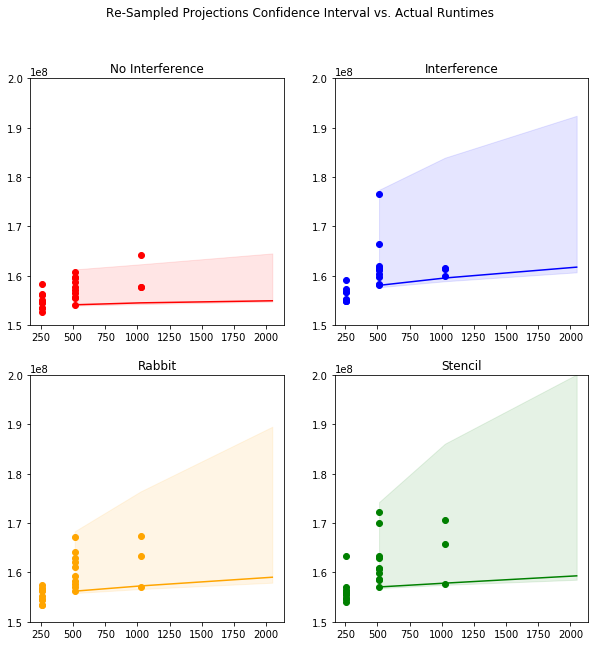

In [9]:
baseranks = 512
kvals = np.array([1, 2, 4])
iterations = 20
cutoff = 1 # ~90% confidence interval with iterations = 20

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Re-Sampled Projections Confidence Interval vs. Actual Runtimes')

count = 0
labels = ['Interference', 'No Interference', 'Stencil', 'Rabbit']

for df in [df_Stampede512_Interference, df_Stampede512_NoInterference, df_Stampede512_Stencil_NoInterference, df_Stampede512_Interference_NoStencil]:    
    print(labels[count])
    
    lowerBound = []
    median = []
    upperBound = []
    for k in kvals:   
        expList = []
        for run in range(0, len(df)):
            currentRun = df.iloc[run]
            eid = currentRun['Experiment']
            rid = currentRun['expid']
            currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
            currentData = analysis.getData(currentPath)
            currentData = currentData[currentData['rank'] == 0]
            
            for i in range(iterations):
                data = analysis.resample_project(currentData, len(currentData), k, col='workload_max_usec')
                projectedRunTime = sum(data)
                expList.append(projectedRunTime)
            expList.sort()
        
        lowerBound.append(expList[0])
        median.append(expList[int(iterations / 2)])
        upperBound.append(expList[-1])
    
    if count == 0:
        _ = axs[0][1].plot(baseranks * kvals, median, color='blue')
        _ = axs[0][1].fill_between(baseranks * kvals, lowerBound, upperBound, color='blue', alpha=.1)
    if count == 1:
        _ = axs[0][0].plot(baseranks * kvals, median, color='red')
        _ = axs[0][0].fill_between(baseranks * kvals, lowerBound, upperBound, color='red', alpha=.1)
    if count == 2:
        _ = axs[1][1].plot(baseranks * kvals, median, color='green')
        _ = axs[1][1].fill_between(baseranks * kvals, lowerBound, upperBound, color='green', alpha=.1)
    if count == 3:
        _ = axs[1][0].plot(baseranks * kvals, median, color='orange')
        _ = axs[1][0].fill_between(baseranks * kvals, lowerBound, upperBound, color='orange', alpha=.1)
    count = count + 1

_ = axs[0][0].plot(NoInterferenceMeta['Ranks'], NoInterferenceMeta['Runtime'], 'o', color='red')
_ = axs[0][0].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[0][0].set_title('No Interference')

_ = axs[0][1].plot(InterferenceMeta['Ranks'], InterferenceMeta['Runtime'], 'o', color='blue')
_ = axs[0][1].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[0][1].set_title('Interference')

_ = axs[1][0].plot(RabbitMeta['Ranks'], RabbitMeta['Runtime'], 'o', color='orange')
_ = axs[1][0].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[1][0].set_title('Rabbit')

_ = axs[1][1].plot(StencilMeta['Ranks'], StencilMeta['Runtime'], 'o', color='green')
_ = axs[1][1].set_ylim([1.5*10**8, 2.0*10**8])
_ = axs[1][1].set_title('Stencil')

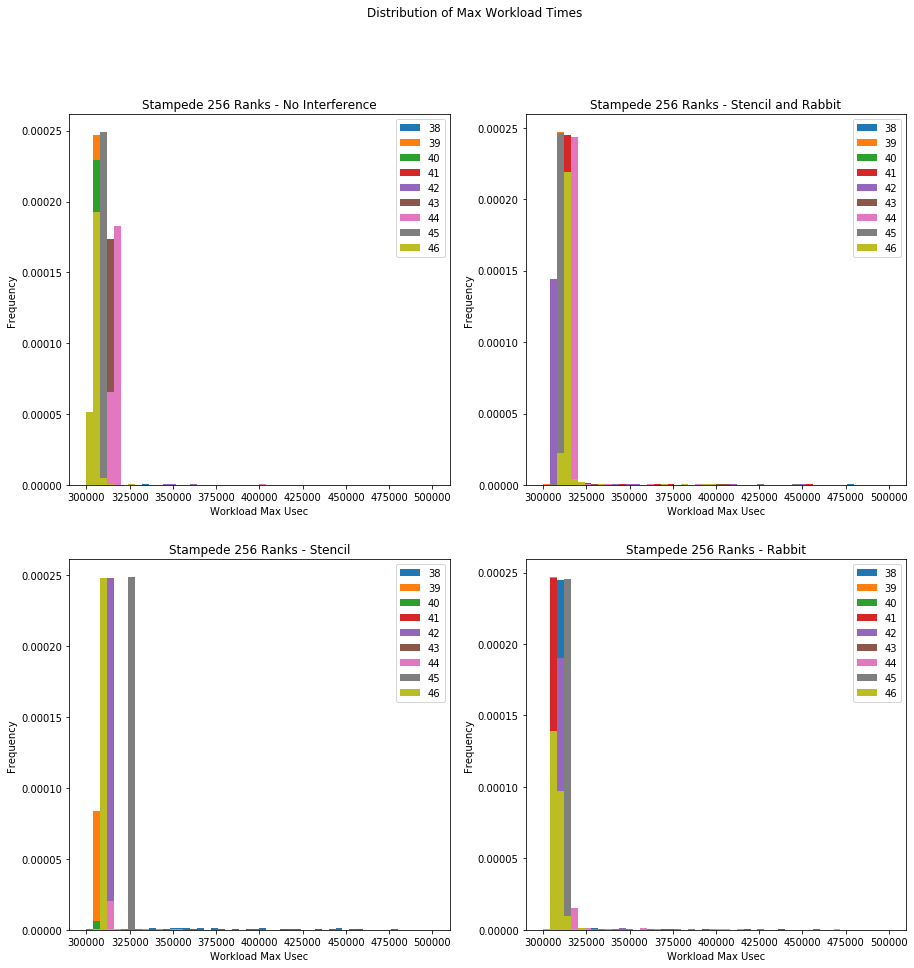

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Distribution of Max Workload Times')

count = 0

for df in [df_Stampede256_NoInterference, df_Stampede256_Stencil_NoInterference, df_Stampede256_Interference, df_Stampede256_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Stampede 256 Ranks - No Interference"
    elif count == 1:
        title = "Stampede 256 Ranks - Stencil"
    elif count == 2:
        title = "Stampede 256 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Stampede 256 Ranks - Rabbit"
        
    # print(title)
    runTimes = []
    shapeList = []
    locList = []
    scaleList = []

    for run in range(0, len(df)):
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'

        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        # shape, loc, scale = gevfit.fit(currentData['interval_max_usec'])

        # print("Runtime:", currentRunTime, "Shape:", shape, "Loc:", loc, "Scale:", scale)
        # print(gevfit.fit_ci(currentData['interval_max_usec']))

        runTimes.append(currentRunTime)
        # shapeList.append(shape)
        # locList.append(loc)
        # scaleList.append(scale)

        _ = axs[i][j].hist(currentData['workload_max_usec'], density=True, label=currentRun['Experiment'], range=[300000, 500000], bins=50)
    _ = axs[i][j].set_title(title)
    _ = axs[i][j].set_xlabel('Workload Max Usec')
    _ = axs[i][j].set_ylabel('Frequency')
    _ = axs[i][j].legend()
    
    if count == 0:
        NoInterferenceRunTime = runTimes
    elif count == 1:
        StencilRunTime = runTimes
    elif count == 2:
        InterferenceRunTime = runTimes
    elif count == 3:
        RabbitRunTime = runTimes
        
    count = count + 1

In [7]:
# Get Runs on Stampede with 512 Ranks  
df_Stampede512_NoInterference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] == 0) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 0) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Interference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==32768) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 1) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Stencil_NoInterference = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==32768) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 0) & (df_Stampede512['osu'] == 0)]
df_Stampede512_Interference_NoStencil = df_Stampede512[(df_Stampede512['workload'] == 'dgemm') & (df_Stampede512['stencil_size'] ==0) & (df_Stampede512['rabbit'] == 0) & (df_Stampede512['rabbit_workload'] == 1) & (df_Stampede512['osu'] == 0)]

Stampede 512 Ranks - No Interference
Stampede 512 Ranks - Stencil
Stampede 512 Ranks - Stencil and Rabbit
Stampede 512 Ranks - Rabbit


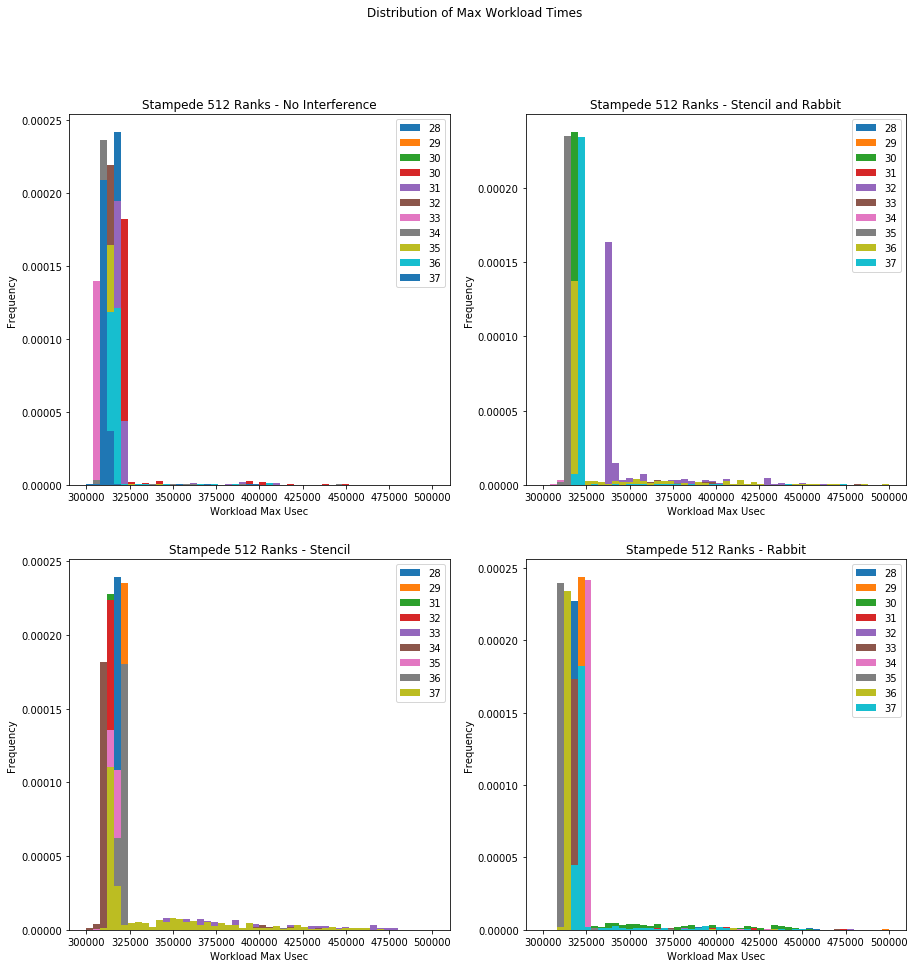

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Distribution of Max Workload Times')

count = 0

for df in [df_Stampede512_NoInterference, df_Stampede512_Stencil_NoInterference, df_Stampede512_Interference, df_Stampede512_Interference_NoStencil]:
    i = count % 2
    j = (int) (count / 2)
    if count == 0:
        title = "Stampede 512 Ranks - No Interference"
    elif count == 1:
        title = "Stampede 512 Ranks - Stencil"
    elif count == 2:
        title = "Stampede 512 Ranks - Stencil and Rabbit"
    elif count == 3:
        title = "Stampede 512 Ranks - Rabbit"
        
    print(title)
    runTimes = []
    shapeList = []
    locList = []
    scaleList = []

    for run in range(0, len(df)):
        currentRun = df.iloc[run]
        eid = currentRun['Experiment']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'

        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        currentRunTime = currentData['interval_max_usec'].sum()
        # shape, loc, scale = gevfit.fit(currentData['interval_max_usec'])

        # print("Runtime:", currentRunTime, "Shape:", shape, "Loc:", loc, "Scale:", scale)
        # print(gevfit.fit_ci(currentData['interval_max_usec']))

        runTimes.append(currentRunTime)
        shapeList.append(shape)
        locList.append(loc)
        scaleList.append(scale)

        _ = axs[i][j].hist(currentData['workload_max_usec'], density=True, label=currentRun['Experiment'], range=[300000, 500000], bins=50)
    _ = axs[i][j].set_title(title)
    _ = axs[i][j].set_xlabel('Workload Max Usec')
    _ = axs[i][j].set_ylabel('Frequency')
    _ = axs[i][j].legend()
    
    if count == 0:
        NoInterferenceRunTime = runTimes
    elif count == 1:
        StencilRunTime = runTimes
    elif count == 2:
        InterferenceRunTime = runTimes
    elif count == 3:
        RabbitRunTime = runTimes
        
    count = count + 1

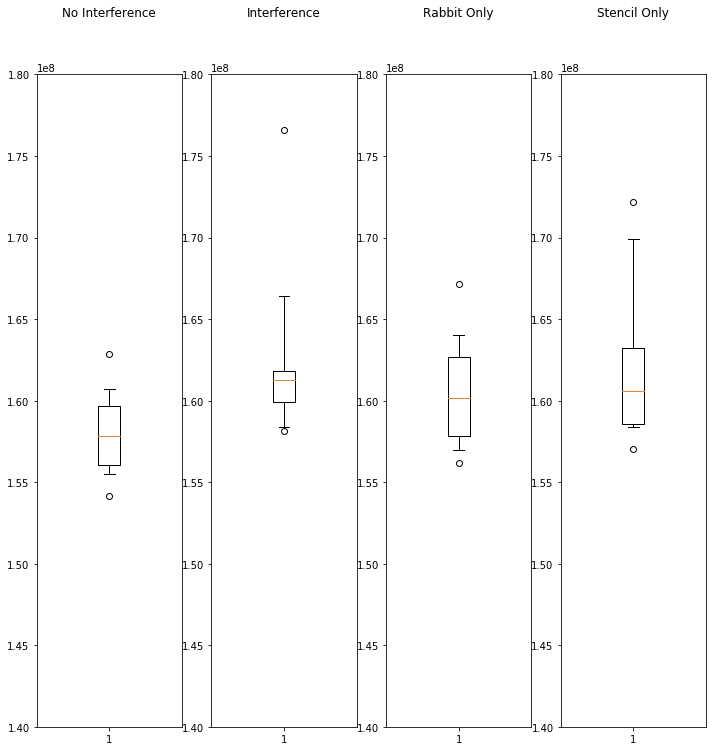

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,12))

_ = axes[0].boxplot(np.array(NoInterferenceRunTime), whis=[0.1/2*100,100-0.1/2*100])
_ = axes[0].set_ylim([1.4*10**8, 1.8*10**8])
_ = axes[0].set_title('No Interference', y=1.08)

_ = axes[1].boxplot(np.array(InterferenceRunTime), whis=[0.1/2*100,100-0.1/2*100])
_ = axes[1].set_ylim([1.4*10**8, 1.8*10**8])
_ = axes[1].set_title('Interference', y=1.08)

_ = axes[2].boxplot(np.array(RabbitRunTime), whis=[0.1/2*100,100-0.1/2*100])
_ = axes[2].set_ylim([1.4*10**8, 1.8*10**8])
_ = axes[2].set_title('Rabbit Only', y=1.08)

_ = axes[3].boxplot(np.array(StencilRunTime), whis=[0.1/2*100,100-0.1/2*100])
_ = axes[3].set_ylim([1.4*10**8, 1.8*10**8])
_ = axes[3].set_title('Stencil Only', y=1.08)

In [20]:
count = 0
for df in [df_Stampede512]:
    for run in range(0, len(df)):
        label = ''
        
        currentRun = df_Stampede512.iloc[run]
        eid = currentRun['Experiment']
        ranks = currentRun['processors']
        stencil = currentRun['stencil_size']
        rab_work = currentRun['rabbit_workload']
        iterations = currentRun['iterations']
        rid = currentRun['expid']
        currentPath = './mlruns/' + str(eid) + '/' + str(rid) + '/artifacts/bsp-trace.json'
        currentData = analysis.getData(currentPath)
        currentData = currentData[currentData['rank'] == 0]
        
        if count == 0:
            NoInterferenceAggregate = pd.DataFrame(columns=currentData.columns)
            StencilAggregate = pd.DataFrame(columns=currentData.columns)
            RabbitAggregate = pd.DataFrame(columns=currentData.columns)
            InterferenceAggregate = pd.DataFrame(columns=currentData.columns)
        
        if int(stencil) > 0:
            label = label + 'Stencil '
        if int(rab_work) > 0:
            label = label + 'Rabbit '
            
        if label == '':
            NoInterferenceAggregate = NoInterferenceAggregate.append(currentData)
        elif label == 'Stencil ':
            StencilAggregate = StencilAggregate.append(currentData)
        elif label == "Rabbit ":
            RabbitAggregate = RabbitAggregate.append(currentData)
        else:
            InterferenceAggregate = InterferenceAggregate.append(currentData)
        count = count + 1

In [21]:
factor = 10
k = 4
iterations = 10

labels = ['Interference', 'NoInterference', 'Stencil_NoRabbit',  'Rabbit_NoStencil']
blockDataList = []

for df in [InterferenceAggregate, NoInterferenceAggregate, StencilAggregate, RabbitAggregate]:
    expList = []
    for i in range(iterations):
        data = analysis.resample_project(df, len(df), k, col='workload_max_usec')
        projectedRunTime = sum(data) / factor
        expList.append(projectedRunTime)
    blockDataList.append(expList)

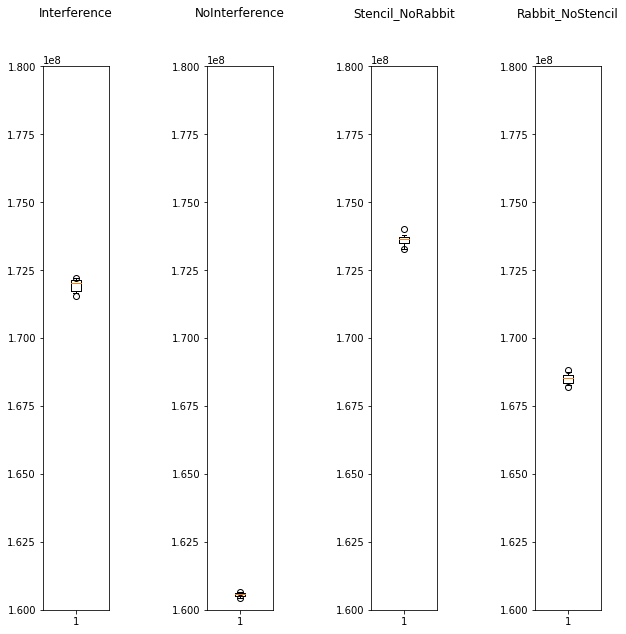

In [23]:
alpha = 0.1

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,10))

for i in range(4):
    axes[i].boxplot(np.array(blockDataList[i]), whis=[alpha/2*100,100-alpha/2*100])
    axes[i].set_title(labels[i], y=1.08)
    axes[i].set_ylim([1.60*10**8, 1.80*10**8])
    
fig.subplots_adjust(hspace=0.6,wspace=1.5)
plt.show()

Interference
No Interference
Stencil
Rabbit


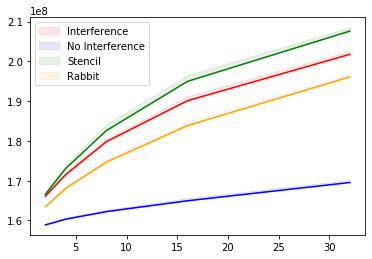

In [25]:
kvals = [2, 4, 8, 16, 32]
iterations = 20
cutoff = 1

fig, ax = plt.subplots()
count = 0
colorlist = ['red', 'blue', 'green', 'orange']
labels = ['Interference', 'No Interference', 'Stencil', 'Rabbit']

for df in [InterferenceAggregate, NoInterferenceAggregate, StencilAggregate, RabbitAggregate]:    
    print(labels[count])
    
    lowerBound = []
    median = []
    upperBound = []
    for k in kvals:   
        expList = []
        for i in range(iterations):
            data = analysis.resample_project(df, len(df), k, col='workload_max_usec')
            projectedRunTime = sum(data) / factor
            expList.append(projectedRunTime)
        expList.sort()
        
        lowerBound.append(expList[cutoff])
        median.append(expList[int(cutoff / 2)])
        upperBound.append(expList[-cutoff])
        
    _ = ax.plot(kvals, median, color=colorlist[count], label=labels[count])
    _ = ax.fill_between(kvals, lowerBound, upperBound, color=colorlist[count], alpha=.1, label=labels[count])
    count = count + 1


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
_ = plt.legend(by_label.values(), by_label.keys())